# Object detection
### csv파일에 저장된 x, y, w, h값을 활용해서 object detection하기.
사용모델 : <br>
https://www.kaggle.com/code/balraj98/yolo-v5-car-object-detection

In [22]:
import os
import cv2
import time
import numpy as np
import pandas as pd

from PIL import Image

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# pytorch
import torch
import torchvision
import torchvision.transforms as T

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset

from tqdm import trange, notebook

In [2]:
path = 'C:/Users/JungHyeona/Documents/deeplearning_seminar/Biometry_20200722/AC/train/'

## data 확인

In [3]:
df = pd.read_csv(path + "labelCoordinate_minmax_01.csv")

In [4]:
df.head()

,image_name,X_min,Y_min,X_max,Y_max
0,20151103_E0000056_I0004613.png,343,111,605,383
1,20151103_E0000057_I0004695.png,453,90,698,335
2,20151103_E0000057_I0004696.png,444,81,677,326
3,20151103_E0000058_I0004790.png,402,235,578,418
4,20151103_E0000059_I0004888.png,401,161,599,359


In [5]:
df["image_name"][2]

'20151103_E0000057_I0004696.png'

### 이미지 불러와서 object 좌표 확인.

(343, 111, 262, 272)


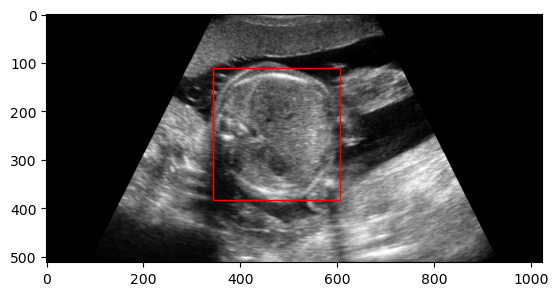

(453, 90, 245, 245)


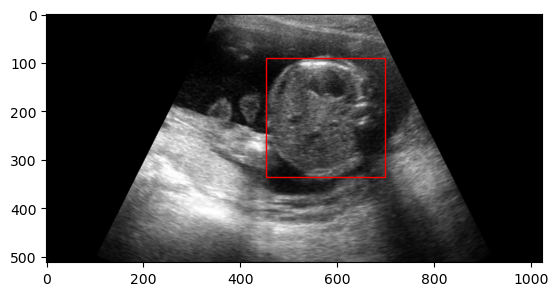

(444, 81, 233, 245)


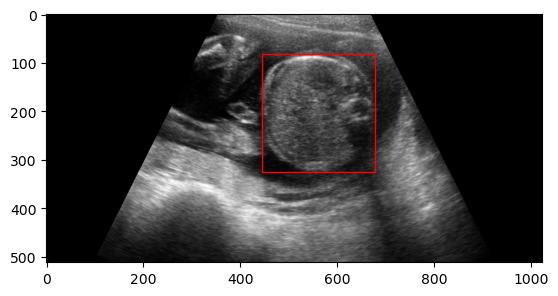

(402, 235, 176, 183)


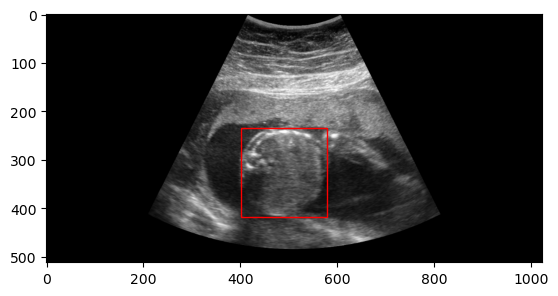

(401, 161, 198, 198)


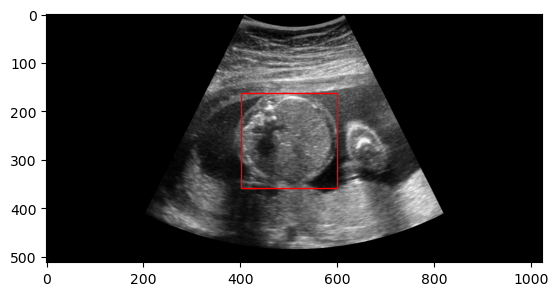

In [6]:
# 5개만 확인해보기
for i in range(5):
    img_path = path + "/image/" + df["image_name"][i]
    img = cv2.imread(img_path)
    xmin = df["X_min"][i]
    ymin = df["Y_min"][i]
    xmax = df["X_max"][i]
    ymax = df["Y_max"][i]

    x = xmin
    y = ymin

    w = xmax - xmin
    h = ymax - ymin


    print(f"{x, y, w, h}")
    fig, ax = plt.subplots()
    ax.imshow(img)
    rect = patches.Rectangle((x,y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.show()

In [7]:
'''
from PIL import Image

img = Image.open(path + 'label/20151216_E0000249_I0021642.png')
img.show()
print(img.size)  # (1024, 512)
(1024, 512)
'''

"\nfrom PIL import Image\n\nimg = Image.open(path + 'label/20151216_E0000249_I0021642.png')\nimg.show()\nprint(img.size)  # (1024, 512)\n(1024, 512)\n"

In [8]:
# 필요 데이터 정리
img_h, img_w, num_channels = (1024, 512, 3)

df_use = pd.read_csv(path + "labelCoordinate_minmax_01.csv")

df_use['x_center'] = (df_use['X_min'] + df_use['X_max'])/2
df_use['y_center'] = (df_use['Y_min'] + df_use['Y_max'])/2
df_use['w'] = df_use['X_max'] - df_use['X_min']
df_use['h'] = df_use['Y_max'] - df_use['Y_min']

df_use['classname'] = 'AC'

'''
df_use['x_center'] = df['x_center']/img_w
df_use['w'] = df_use['w']/img_w
df_use['y_center'] = df_use['y_center']/img_h
df_use['h'] = df_use['h']/img_h
'''

"\ndf_use['x_center'] = df['x_center']/img_w\ndf_use['w'] = df_use['w']/img_w\ndf_use['y_center'] = df_use['y_center']/img_h\ndf_use['h'] = df_use['h']/img_h\n"

In [ ]:
df_use

In [8]:
df['w'] = df['X_max'] - df['X_min']
df['h'] = df['Y_max'] - df['Y_min']
df['classname'] = 'AC'

In [9]:
df

,image_name,X_min,Y_min,X_max,Y_max,w,h,classname
0,20151103_E0000056_I0004613.png,343,111,605,383,262,272,AC
1,20151103_E0000057_I0004695.png,453,90,698,335,245,245,AC
2,20151103_E0000057_I0004696.png,444,81,677,326,233,245,AC
3,20151103_E0000058_I0004790.png,402,235,578,418,176,183,AC
4,20151103_E0000059_I0004888.png,401,161,599,359,198,198,AC
...,...,...,...,...,...,...,...,...
10080,20190531_E0008423_I0148963.png,344,99,661,386,317,287,AC
10081,20190531_E0008424_I0148970.png,335,76,680,379,345,303,AC
10082,20190531_E0008424_I0148974.png,368,79,730,404,362,325,AC
10083,20190531_E0008430_I0149113.png,412,120,597,293,185,173,AC


## 훈련을 위한 dataset 준비

In [11]:
### Total Classes

classes = df["classname"].unique()
print("Total Classes: ",len(classes))
print("\n> Classes <\n",classes)

Total Classes:  1

> Classes <
 ['AC']


In [12]:
# 잘 박스 처리 되는지 확인.
def plot_img(image_name):
    
    fig, ax = plt.subplots(1, 2, figsize = (14, 14))
    ax = ax.flatten()
    
    bbox = df[df['image_name'] == image_name]
    img_path = os.path.join(path + '/image', image_name)
    
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    image2 = image
    
    ax[0].set_title('Original Image')
    ax[0].imshow(image)
    
    for idx, row in bbox.iterrows():
        x1 = row['X_min']
        y1 = row['Y_min']
        x2 = row['X_max']
        y2 = row['Y_max']
        #label = row['classname']
        label = 'AC'
        
        cv2.rectangle(image2, (int(x1),int(y1)), (int(x2),int(y2)), (255,0,0), 3)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image2, label, (int(x1),int(y1-10)), font, 1, (255,0,0), 2)
    
    ax[1].set_title('Image with Bondary Box')
    ax[1].imshow(image2)

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


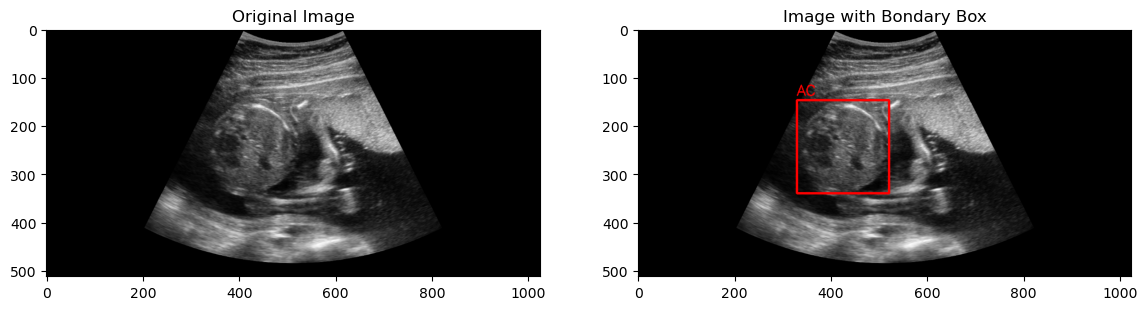

In [13]:
plot_img('20151104_E0000052_I0004261.png')

In [14]:
### Class <-> Int

_classes = np.insert(classes, 0, "background", axis=0)        # adding a background class for Faster R-CNN
class_to_int = {_classes[i] : i for i in range(len(_classes))}
int_to_class = {i : _classes[i] for i in range(len(_classes))}
print("class_to_int : \n",class_to_int)
print("\nint_to_class : \n",int_to_class)

class_to_int : 
 {'background': 0, 'AC': 1}

int_to_class : 
 {0: 'background', 1: 'AC'}


In [15]:
### Creating Data (Labels & Targets) for Faster R-CNN

class FaceMaskDetectionDataset(Dataset):
    
    def __init__(self, dataframe, image_dir, mode = 'train', transforms = None):
        
        super().__init__()
        
        self.image_names = dataframe["image_name"].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        self.mode = mode
        
    def __getitem__(self, index: int):
        
        #Retrive Image name and its records (x1, y1, x2, y2, classname) from df
        image_name = self.image_names[index]
        records = self.df[self.df["image_name"] == image_name]
        
        #Loading Image
        image = cv2.imread(self.image_dir + image_name, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        if self.mode == 'train':
            
            #Get bounding box co-ordinates for each box
            boxes = records[['X_min', 'Y_min', 'X_max',	'Y_max']].values

            #Getting labels for each box
            temp_labels = records[['classname']].values
            labels = []
            for label in temp_labels:
                label = class_to_int[label[0]]
                labels.append(label)

            #Converting boxes & labels into torch tensor
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)

            #Creating target
            target = {}
            target['boxes'] = boxes
            target['labels'] = labels

            #Transforms
            if self.transforms:
                image = self.transforms(image)


            return image, target, image_name
        
        elif self.mode == 'test':

            if self.transforms:
                image = self.transforms(image)

            return image, image_name
    
    def __len__(self):
        return len(self.image_names)

In [16]:
### Transform for Train & Valid

def get_transform():
    return T.Compose([T.ToTensor()])

In [17]:
### Preparing data for Train & Validation

def collate_fn(batch):
    return tuple(zip(*batch))


#Dataset object
dataset = FaceMaskDetectionDataset(df, path + '/image', transforms = get_transform())


# split the dataset in train and test set - using 80% for training, 20% for validation
indices = torch.randperm(len(dataset)).tolist()
train_dataset = torch.utils.data.Subset(dataset, indices[:-866])
valid_dataset = torch.utils.data.Subset(dataset, indices[-866:])


#Preparing data loaders
train_data_loader = DataLoader(
    train_dataset,
    batch_size = 64,
    shuffle = True,
    num_workers = 4,
    collate_fn = collate_fn
)


valid_data_loader = DataLoader(
    valid_dataset,
    batch_size = 64,
    shuffle = True,
    num_workers = 4,
    collate_fn = collate_fn
)

In [ ]:
train_data_loader

## 모델 만들기

In [21]:
### Utilize GPU if available

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

In [18]:
### Create / load model

#Faster - RCNN Model - pretrained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone = False)
num_classes = len(class_to_int)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

C:\Users\JungHyeona\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\JungHyeona\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\JungHyeona\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and will be removed in 0.15, please use 'weights_backbone' instead.
  warnings.warn(
C:\Users\JungHyeona\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and will be removed in 0.15. The current behavior is eq

## 파라미터 정의

In [20]:
### Preparing model for training

#Retriving all trainable parameters from model (for optimizer)
params = [p for p in model.parameters() if p.requires_grad]

#Defininig Optimizer
#optimizer = torch.optim.Adam(params, lr = 0.0001)
optimizer = torch.optim.SGD(params, lr = 0.005, momentum = 0.9)

#LR
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

'''
#Load pre-trained model
checkpoint = torch.load("../input/face-mask-detection-trained-weights/fmd_frcnn_e23.pth")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
'''

model#.to(device)

#No of epochs
epochs = 5

## 훈련

In [ ]:
itr = 1
total_train_loss = []

for epoch in notebook.tqdm(range(epochs)):
    print("START")
    start_time = time.time()
    train_loss = []
    
    #Retriving Mini-batch
    for images, targets, image_names in train_data_loader:
        print("loadering")
        #Loading images & targets on device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        #Forward propagation
        out = model(images, targets)
        losses = sum(loss for loss in out.values())
        
        #Reseting Gradients
        optimizer.zero_grad()
        
        #Back propagation
        losses.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        
        #Average loss
        loss_value = losses.item()
        train_loss.append(loss_value)
        
        if itr % 25 == 0:
            print(f"\n Iteration #{itr} loss: {out} \n")

        itr += 1
    
    #lr_scheduler.step()    
    
    epoch_train_loss = np.mean(train_loss)
    total_train_loss.append(epoch_train_loss)
    print(f'Epoch train loss is {epoch_train_loss:.4f}')

    
    time_elapsed = time.time() - start_time
    print("Time elapsed: ",time_elapsed)
    
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_train_loss
            })#, "checkpoint.pth")

  0%|          | 0/5 [00:00<?, ?it/s]

START


## validation

In [ ]:
itr = 1
v_loss = []

start_time = time.time()

for images, targets, image_names in valid_data_loader:
        
    #Loading images & targets on device
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
    #Forward propagation
    out = model(images, targets)
    losses = sum(loss for loss in out.values())
        
    #Average loss
    loss_value = losses.item()
    v_loss.append(loss_value)

val_loss = np.mean(v_loss)
print(f'Val loss is {val_loss:.4f}')
 
time_elapsed = time.time() - start_time
print("Time elapsed: ",time_elapsed)

## 요약

In [ ]:
submission = pd.DataFrame(columns = ["name", "x1", "x2", "y1", "y2", "classname"])
submission.head()

In [ ]:
### 0 - 1800 (Test Images)

images = sorted(os.listdir(path + '/image'))
test_images = images[ : 1698]

#Use submission.csv (from dataset) as temp
test_df = pd.read_csv(DIR_INPUT + "submission.csv")
test_df = test_df.drop_duplicates(subset='name', keep="first")

In [ ]:
### Preparing Training Data

#Test Dataset
test_dataset = FaceMaskDetectionDataset(test_df, path + '/image', mode = 'test', transforms = get_transform())

#Test data loader
test_data_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=1,
    drop_last=False,
    collate_fn=collate_fn
)

# 결과

In [ ]:
### Results - may take few mins, please wait!

threshold = 0.9
model.eval()

for images, image_names in test_data_loader:

    #Forward ->
    images = list(image.to(device) for image in images)
    output = model(images)
    
    #Converting tensors to array
    boxes = output[0]['boxes'].data.cpu().numpy()
    scores = output[0]['scores'].data.cpu().numpy()
    labels = output[0]['labels'].data.cpu().numpy()
    
    #Thresholding
    boxes_th = boxes[scores >= threshold].astype(np.int32)
    scores_th = scores[scores >= threshold]
    
    # int_to_class - labels
    labels_th = []
    for x in range(len(labels)):
        if scores[x] > threshold:
            labels_th.append(int_to_class[labels[x]])
    
    #Appending results to csv
    for y in range(len(boxes_th)):
        
        #Bboxes, classname & image name
        x1 = boxes_th[y][0]
        y1 = boxes_th[y][1]
        x2 = boxes_th[y][2]
        y2 = boxes_th[y][3]
        class_name = labels_th[y]
        
        #Creating row for df
        row = {"name" : image_names[0], "x1" : x1, "x2" : x2, "y1" : y1, "y2" : y2, "classname" : class_name}
        
        #Appending to df
        submission = submission.append(row, ignore_index = True)
    

In [ ]:
submission.to_csv('submission.csv', index = False)